In [35]:
from typing import TypedDict, List, Annotated, Sequence 


#classes for messages
from langchain_core.messages import BaseMessage # Foundational class for all msg types in langgraph
from langchain_core.messages import ToolMessage # passes tool produced by content back to LLM 
from langchain_core.messages import SystemMessage # message for providing instructions to the LLM

from langchain_core.tools import tool

# add_messages is a reducer function aka rule that controls how updates from nodes are combined inside the existing state
    # appends new content to the current state. Without it, updates will replace the existing value entirely
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

In [36]:
from langchain_google_genai import ChatGoogleGenerativeAI


from dotenv import load_dotenv
import os
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_GENAI_API_TOKEN")

from langchain_tavily import TavilySearch

TAVILY_KEY = os.getenv("AGENT_TAVILY_API_KEY")



In [37]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [38]:
tavily_search = TavilySearch(
    tavily_api_key=TAVILY_KEY,
    max_results=5,
    topic="general",
    include_answer=True,
    # include_images=False,
    # include_image_descriptions=False,
    search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [39]:
@tool
def add(a:int, b:int):
    """This function adds two given numbers"""
    return a + b

@tool
def multiply(a:int, b:int):
    """This function multiplies two given numbers"""
    return a + b


    


In [40]:
tools = [add, multiply, tavily_search]

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",  
    temperature=0,
    google_api_key=GOOGLE_API_KEY
).bind_tools(tools)

In [ ]:
def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content= 
    """You are a general AI assistant. 
        I will ask you a question. 
        Report your thoughts, and give your FINAL ANSWER directly without using any template. 
        YOUR FINAL ANSWER should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. 
        If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. 
        If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. 
        If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.""")
    response = llm.invoke([system_prompt] + state["messages"])
    return{"messages":[response]}

In [42]:
def should_continue(state:AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

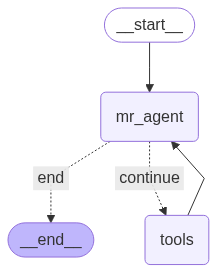

In [43]:
graph = StateGraph(AgentState)

graph.add_node("mr_agent", model_call)

# tool node is used to attach the tools to the graph
tool_node = ToolNode(tools=tools)
graph.add_node("tools", tool_node)

graph.set_entry_point("mr_agent")

graph.add_conditional_edges(
    "mr_agent", 
    should_continue,

    {
        "continue":"tools",
        "end":END,
    }
)

graph.add_edge("tools", "mr_agent")

app = graph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [44]:
inputs = {"messages": [("user", "What is the first name of the only Malko Competition recipient from the 20th Century (after 1977) whose nationality on record is a country that no longer exists?")]}

In [45]:
def print_stream(stream):
    for step in stream:
        message = step["messages"][-1]
        if isinstance(message,tuple):
            print(message)
        else:
            message.pretty_print()

print_stream(app.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What is the first name of the only Malko Competition recipient from the 20th Century (after 1977) whose nationality on record is a country that no longer exists?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (78d47ed1-1d96-48d8-8ef4-3a31ebfbcea2)
 Call ID: 78d47ed1-1d96-48d8-8ef4-3a31ebfbcea2
  Args:
    search_depth: advanced
    query: Malko Competition recipients 20th century nationality country no longer exists
================================= Tool Message =================================
Name: tavily_search

{"query": "Malko Competition recipients 20th century nationality country no longer exists", "follow_up_questions": null, "answer": "The only Malko Competition recipient from the 20th century with a nationality from a country that no longer exists is Claus Peter Flor, from Germany.", "images": [], "results": [{"url": "https://hugging